<a href="https://colab.research.google.com/github/KarelZe/thesis/blob/accuracy/notebooks/4.0b-mb-gbm_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost==1.1
!pip install gcsfs==2022.10.0
!pip install numpy==1.23.4
!pip install pandas==1.5.1
!pip install scikit-learn==1.1.3
!pip install fastparquet
!pip install wandb --upgrade
!pip install optuna

  Using cached gcsfs-2022.10.0-py2.py3-none-any.whl (25 kB)
  Using cached fsspec-2022.10.0-py3-none-any.whl (138 kB)
ERROR: otc 0.0.1 has requirement gcsfs==2022.11.0, but you'll have gcsfs 2022.10.0 which is incompatible.
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2022.11.0
    Uninstalling fsspec-2022.11.0:
      Successfully uninstalled fsspec-2022.11.0
  Attempting uninstall: gcsfs
    Found existing installation: gcsfs 2022.11.0
    Uninstalling gcsfs-2022.11.0:
      Successfully uninstalled gcsfs-2022.11.0
     |████████████████████████████████| 1.9 MB 1.9 MB/s eta 0:00:01
ERROR: otc 0.0.1 has requirement gcsfs==2022.11.0, but you'll have gcsfs 2022.10.0 which is incompatible.
ERROR: otc 0.0.1 has requirement wandb==0.13.5, but you'll have wandb 0.13.7 which is incompatible.
  Attempting uninstall: wandb
    Found existing installation: wandb 0.13.5
    Uninstalling wandb-0.13.5:
      Successfully uninstalled wandb-0.13.5
     |█████████████████████

Run `pip install .` first to install all dependencies.

In [2]:
from catboost import CatBoostClassifier

import json

import gcsfs

import numpy as np
import pandas as pd

import os
from pathlib import Path

from sklearn.metrics import accuracy_score
import wandb

from typing import List, Optional

import pickle
import optuna

In [3]:
# connect to google cloud storage
# import google.auth
# from google.colab import auth, output
# auth.authenticate_user()
# credentials, _ = google.auth.default()
# fs = gcsfs.GCSFileSystem(project="thesis", token=credentials)
fs = gcsfs.GCSFileSystem(project="thesis")
fs_prefix = "gs://"

/usr/local/lib/python3.8/dist-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [8]:
features_classical_size = [
    "TRADE_PRICE",
    "bid_ask_size_ratio_ex",
    "rel_bid_size_ex",
    "rel_ask_size_ex",
    "depth_ex",
    "prox_ex",
    "prox_best",
    "spread_ex",
    "spread_best",
    "bid_ask_ratio_ex",
    "price_rel_nbb",
    "price_rel_nbo",
    "chg_ex_lead",
    "chg_ex_lag",
    "chg_all_lead",
    "chg_all_lag",
    "ask_ex",
    "bid_ex",
    "BEST_ASK",
    "BEST_BID",
    "price_all_lag",
    "price_all_lead",
    "price_ex_lag",
    "price_ex_lead",
    "TRADE_SIZE",
    "bid_size_ex",
    "ask_size_ex",
]

In [9]:
os.environ["GCLOUD_PROJECT"] = "flowing-mantis-239216"

In [10]:
# see https://wandb.ai/fbv/thesis/runs/kwlaw02g/overview?workspace=user-karelze
run = wandb.init(project="thesis",entity="fbv")

dataset = "fbv/thesis/ise_classic_size_log_normalized:v0"
artifact = run.use_artifact(dataset)
data_dir = artifact.download()

study = "fbv/thesis/37m52gu6.optuna:v19"
artifact = run.use_artifact(study)
study_dir = artifact.download()


model = "fbv/thesis/37m52gu6_CatBoostClassifier_default.cbm:v5"
model_name = model.split("/")[-1].split(":")[0]

artifact = run.use_artifact(model)
model_dir = artifact.download()

wandb: Downloading large artifact ise_classic_size_log_normalized:v0, 4345.50MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.0
wandb:   1 of 1 files downloaded.  
wandb:   2 of 2 files downloaded.  


In [11]:
X_test = pd.read_parquet(Path(data_dir, "test_set_20.parquet"), engine="fastparquet")

y_test = X_test["buy_sell"]
y_test[y_test<0] = 0
X_test = X_test[features_classical_size]


<ipython-input-11-800bdc36999a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test[y_test<0] = 0


## CatBoost Baseline 🐈‍⬛

## Visualize study

<ipython-input-12-aa4a9ba97c8e>:4: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)
<ipython-input-12-aa4a9ba97c8e>:5: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)
<ipython-input-12-aa4a9ba97c8e>:6: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)
<ipython-input-12-aa4a9ba97c8e>:7: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(
[W 2022-12-18 14:58:03,786] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f46ddf87850>,
      dtype=object)

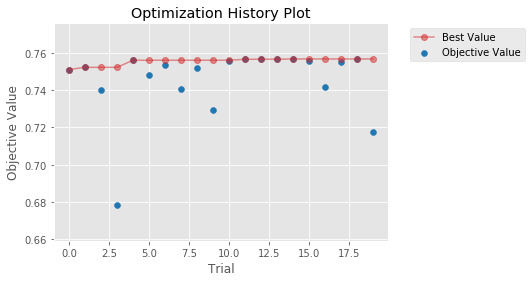

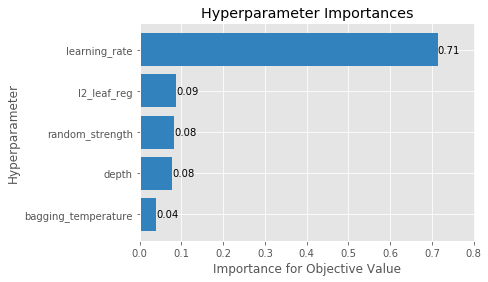

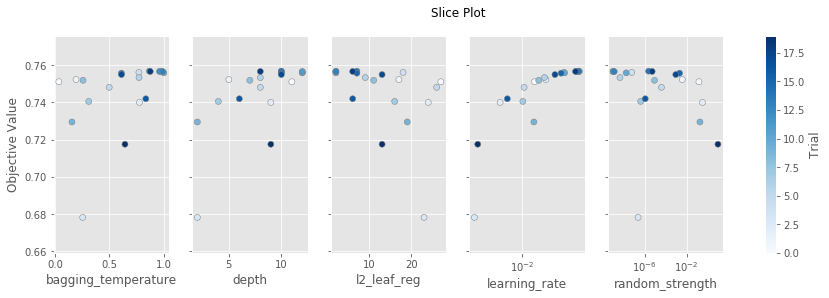

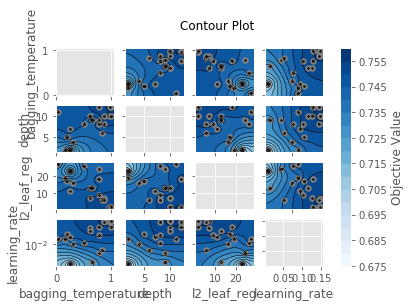

In [12]:
file = file = open("./artifacts/37m52gu6.optuna:v19/37m52gu6.optuna",'rb')
study = pickle.load(file)

optuna.visualization.matplotlib.plot_optimization_history(study)
optuna.visualization.matplotlib.plot_param_importances(study)
optuna.visualization.matplotlib.plot_slice(study)
optuna.visualization.matplotlib.plot_contour(
     study, ["learning_rate", "depth", "bagging_temperature", "l2_leaf_reg"]
)

### Learning Curves Baseline 📉

In [13]:
%%script false --no-raise-error
# visualize learning curves
with open(Path(model_dir,model_name[:-4]+"_training.json"), 'r') as j:
     contents = json.loads(j.read())

# extract relevant keys
test_metrics = [d['name'] for d in contents['meta']['test_metrics'] ]
test_results = [d['test'] for d in iterations]
learn_metrics = [d['name'] for d in contents['meta']['learn_metrics'] ]
learn_results = [d['learn'] for d in iterations]

metrics_learn = pd.DataFrame(learn_results, columns=learn_metrics).add_prefix("learn_")
metrics_test = pd.DataFrame(test_results, columns=test_metrics).add_prefix("test_")

learning_metrics = pd.concat([metrics_learn, metrics_test], axis=1)

df.head()

In [14]:
%%script false --no-raise-error
learning_metrics.plot(kind="line", figsize=(16,9))

### Accuracy Baseline 🎯

In [15]:
model = CatBoostClassifier()
model.load_model(fname=Path(model_dir, model_name))

In [16]:
acc = model.score(X_test, y_test)
print(acc)

/usr/local/lib/python3.8/dist-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0.7283596455576674


### Robustness Baseline🥊

In [17]:
# load default data to use unscaled version with all possible columns
X_print = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/test_set_extended_20.parquet",
    engine="fastparquet",
    columns=["EXPIRATION", "QUOTE_DATETIME", "OPTION_TYPE", "TRADE_SIZE", "myn", "buy_sell", "issue_type"]
)

/usr/local/lib/python3.8/dist-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [18]:
# Copy unscaled columns
X_print = X_print.copy()
X_print["buy_sell"] = (X_print["buy_sell"] > 0).astype(int)

# add baseline results
X_print["rule"] = "Baseline"
X_print["buy_sell_predicted"] = model.predict(X_test)

# prepare columns for printing
X_print["ttm"] = (
    X_print["EXPIRATION"].dt.to_period("M")
    - X_print["QUOTE_DATETIME"].dt.to_period("M")
).apply(lambda x: x.n)
X_print["year"] = X_print["QUOTE_DATETIME"].dt.year

bins_tradesize = [-np.inf, 1, 3, 5, 11, np.inf]
trade_size_labels = ["(0,1]", "(1,3]", "(3,5]", "(5,11]", ">11"]
X_print["TRADE_SIZE_binned"] = pd.cut(
    X_print["TRADE_SIZE"], bins_tradesize, labels=trade_size_labels
)

bins_years = [2004, 2007, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
year_labels = [
    "2005-2007",
    "2008-2010",
    "2011",
    "2012",
    "2013",
    "2014",
    "2015",
    "2016",
    "2017",
]
X_print["year_binned"] = pd.cut(X_print["year"], bins_years, labels=year_labels)

bins_ttm = [-np.inf, 1, 2, 3, 6, 12, np.inf]
ttm_labels = [
    "ttm <= 1 month",
    "ttm (1-2] month",
    "ttm (2-3] month",
    "ttm (3-6] month",
    "ttm (6-12] month",
    "ttm > 12 month",
]
X_print["ttm_binned"] = pd.cut(X_print["ttm"], bins_ttm, labels=ttm_labels)


bins_myn = [-np.inf, 0.7, 0.9, 1.1, 1.3, np.inf]
myn_labels = [
    "mny <=0.7",
    "mny (0.7-0.9]",
    "mny (0.9-1.1]",
    "mny (1.1-1.3]",
    "mny > 1.3",
]
X_print["myn_binned"] = pd.cut(X_print["myn"], bins_myn, labels=myn_labels)

X_print["issue_type_binned"] = X_print["issue_type"].replace(
    {"0": 'Stock options', 'A': 'Index options', '7': 'Others',
     'F': 'Others', '%': 'Others', ' ': 'Others'})


# TODO: time from previous trade; same underlying or any?


/usr/local/lib/python3.8/dist-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [19]:
X_print.head()

,EXPIRATION,QUOTE_DATETIME,OPTION_TYPE,TRADE_SIZE,myn,buy_sell,issue_type,rule,buy_sell_predicted,ttm,year,TRADE_SIZE_binned,year_binned,ttm_binned,myn_binned,issue_type_binned
39342171,2015-12-18,2015-11-06 09:30:00,P,2,0.921659,0,%,Baseline,0,1,2015,"(1,3]",2015,ttm <= 1 month,mny (0.9-1.1],Others
39342172,2015-11-27,2015-11-06 09:30:00,C,1,1.001696,0,0,Baseline,0,0,2015,"(0,1]",2015,ttm <= 1 month,mny (0.9-1.1],Stock options
39342173,2017-01-20,2015-11-06 09:30:00,C,1,0.886115,0,0,Baseline,0,14,2015,"(0,1]",2015,ttm > 12 month,mny (0.7-0.9],Stock options
39342174,2015-11-20,2015-11-06 09:30:00,C,1,1.009261,1,%,Baseline,1,0,2015,"(0,1]",2015,ttm <= 1 month,mny (0.9-1.1],Others
39342175,2015-12-18,2015-11-06 09:30:00,C,1,0.991880,0,%,Baseline,0,1,2015,"(0,1]",2015,ttm <= 1 month,mny (0.9-1.1],Others


In [20]:
def check_robustness(criterion: str = "year_binned") -> pd.DataFrame:
    """
    Check robustness of rules by calculating the accuracy for a given
    criterion and rules.

    Example:
    rule		Baseline
    TRADE_SIZE_binned
    (0,1]	  0.710966
    (1,3]	  0.717664
    (3,5]	  0.715195
    (5,11]	0.699428
    >11	  	0.688348

    Args:
        criterion (str, optional): criterion to check robustness for.
        Defaults to "year_binned".

    Returns:
        pd.DataFrame: DataFrame with accuracy of rules. Rule in columns and
        criterion values in rows.
    """

    # fill others randomly with equal weight for every class.
    X_print["buy_sell_predicted"] = X_print["buy_sell_predicted"].map(
        lambda l: l if not np.isnan(l) else np.random.choice([0, 1])
    )

    # cuculate average over columns if multiple subsets are combined
    results = (
        X_print.groupby(["rule", criterion])[["buy_sell", "buy_sell_predicted"]]
        .apply(lambda x: accuracy_score(x["buy_sell"], x["buy_sell_predicted"]))
        .unstack(level=0)
        .assign(avg=lambda x: x.mean(axis=1))
    )
    return results


In [21]:
X_print.head()


,EXPIRATION,QUOTE_DATETIME,OPTION_TYPE,TRADE_SIZE,myn,buy_sell,issue_type,rule,buy_sell_predicted,ttm,year,TRADE_SIZE_binned,year_binned,ttm_binned,myn_binned,issue_type_binned
39342171,2015-12-18,2015-11-06 09:30:00,P,2,0.921659,0,%,Baseline,0,1,2015,"(1,3]",2015,ttm <= 1 month,mny (0.9-1.1],Others
39342172,2015-11-27,2015-11-06 09:30:00,C,1,1.001696,0,0,Baseline,0,0,2015,"(0,1]",2015,ttm <= 1 month,mny (0.9-1.1],Stock options
39342173,2017-01-20,2015-11-06 09:30:00,C,1,0.886115,0,0,Baseline,0,14,2015,"(0,1]",2015,ttm > 12 month,mny (0.7-0.9],Stock options
39342174,2015-11-20,2015-11-06 09:30:00,C,1,1.009261,1,%,Baseline,1,0,2015,"(0,1]",2015,ttm <= 1 month,mny (0.9-1.1],Others
39342175,2015-12-18,2015-11-06 09:30:00,C,1,0.991880,0,%,Baseline,0,1,2015,"(0,1]",2015,ttm <= 1 month,mny (0.9-1.1],Others


In [22]:
check_robustness("year_binned")


rule,Baseline,avg
year_binned,,
2015,0.697746,0.697746
2016,0.730686,0.730686
2017,0.733271,0.733271


In [23]:
check_robustness("OPTION_TYPE")


rule,Baseline,avg
OPTION_TYPE,,
C,0.723808,0.723808
P,0.733558,0.733558


In [24]:
check_robustness("issue_type_binned")

rule,Baseline,avg
issue_type_binned,,
Index options,0.579754,0.579754
Others,0.767997,0.767997
Stock options,0.714650,0.714650


In [25]:
check_robustness("TRADE_SIZE_binned")


rule,Baseline,avg
TRADE_SIZE_binned,,
"(0,1]",0.730615,0.730615
"(1,3]",0.735080,0.735080
"(3,5]",0.733318,0.733318
"(5,11]",0.722385,0.722385
>11,0.716861,0.716861


In [26]:
check_robustness("ttm_binned")


rule,Baseline,avg
ttm_binned,,
ttm <= 1 month,0.732264,0.732264
ttm (1-2] month,0.732721,0.732721
ttm (2-3] month,0.723627,0.723627
ttm (3-6] month,0.718143,0.718143
ttm (6-12] month,0.716201,0.716201
ttm > 12 month,0.695536,0.695536


In [27]:
check_robustness("myn_binned")


rule,Baseline,avg
myn_binned,,
mny <=0.7,0.720464,0.720464
mny (0.7-0.9],0.744974,0.744974
mny (0.9-1.1],0.733867,0.733867
mny (1.1-1.3],0.677745,0.677745
mny > 1.3,0.646164,0.646164
